# Examine the laser intensity profile

The laser width definition is a difficult parameter. Per definition, the laser beam shape is based on a Gaussian distribution with a shape factor (shape factor of 1 (**Raffel et al. claims that it must be equal to 2, but this is not correct!**) is Gaussian profile, larger values will result in more top-hat shaped beams). The laser width $\Delta Z0$ is where the (normalized) intensity drops to $-1/\sqrt{2\pi} \approx 0.67$:

\begin{equation}
I_0(Z) = q \cdot exp\left[ -\frac{1}{\sqrt{(2\pi)}} \left\| \frac{2 Z^2}{\Delta Z_0^2} \right\|^s \right]
\end{equation}

The laser width is $\Delta Z$ and the shape factor is $s$. However, this is not the physical width! Why? Let's build a 

In [1]:
import numpy as np

from synpivimage import take_image, Camera, Laser, Particles
import synpivimage as spi 
spi.__version__

'1.0.0'

## Gaussian laser beam vs. top-hat

Shape factor $s$=1, top-hat-like uses $s=10$, both width $\Delta Z=1$

In [2]:
z = np.linspace(-2, 2, 10000)
gauss_laser = Laser(
    width=1,
    shape_factor=1
)
tophat_laser = Laser(
    width=1,
    shape_factor=10
)

Position particles

In [3]:
many_particles = Particles(
    x=np.ones_like(z),
    y=np.ones_like(z),
    z=z,
    size=np.ones_like(z)
)

In [4]:
gauss_iluminated_particles = gauss_laser.illuminate(many_particles)
tophat_iluminated_particles = tophat_laser.illuminate(many_particles)

In [5]:
import matplotlib.pyplot as plt

Notice how both laser beam profiles will intersect the same intensity at $I/I_0=0.67$

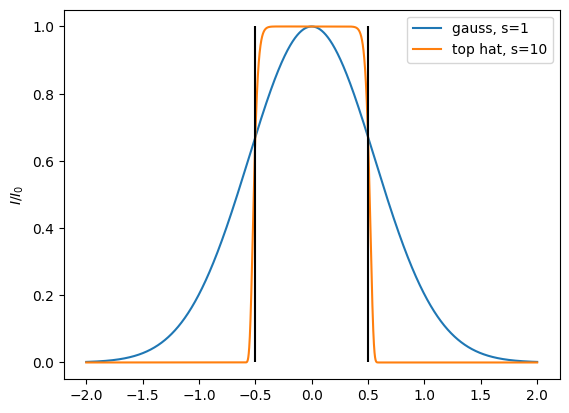

In [6]:
plt.plot(z, gauss_iluminated_particles.irrad_photons, label='gauss, s=1')
plt.plot(z, tophat_iluminated_particles.irrad_photons, label='top hat, s=10')
plt.vlines(-gauss_laser.width/2, 0, 1, color='k')
plt.vlines(gauss_laser.width/2, 0, 1, color='k')
plt.ylabel('$I/I_0$')
plt.legend()

Whether or not a particle will be illuminated (also outside $\Delta Z_0$) depends on the noise level. With no noise, the limit is set to $\exp(-2)$:

In [7]:
cam = Camera(
    nx=16,
    ny=16,
    bit_depth=16,
    qe=1,
    sensitivity=1,
    baseline_noise=0,
    dark_noise=0,
    shot_noise=False,
    fill_ratio_x=1.0,
    fill_ratio_y=1.0,
    particle_image_diameter=1.0
)

In [8]:
n = 400
many_particles = Particles(
    x=np.ones(n)*cam.nx//2,
    y=np.ones(n)*cam.ny//2,
    z=np.linspace(-3*gauss_laser.width / 2, 3*gauss_laser.width/2, n),
    size=np.ones(n)*2
)

In [9]:
imgOne, partOne = take_image(gauss_laser, cam, many_particles, particle_peak_count=1000)

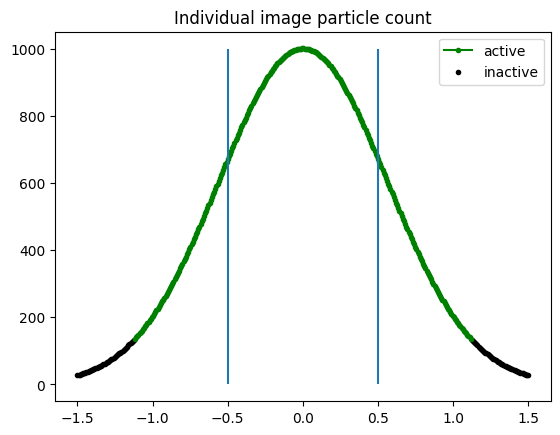

In [10]:
plt.plot(partOne.z[partOne.active], partOne.max_image_photons[partOne.active], marker='.', color='g', label='active')
plt.scatter(partOne.z[~partOne.active], partOne.max_image_photons[~partOne.active], marker='.', color='k', label='inactive')
plt.title('Individual image particle count')
plt.vlines(-gauss_laser.width/2, 0, 1000)
plt.vlines(gauss_laser.width/2, 0, 1000)
plt.legend()

# Influence of the noise level to the effective laser width

If the Gaussian noise (`dark_noise`) is larger than a particle than it cannot be seen, hence this defines the laser width:

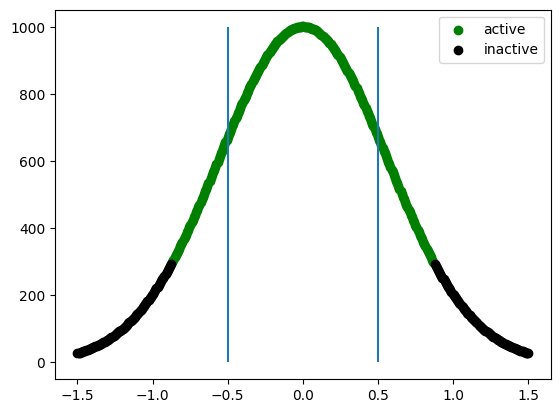

In [15]:
laser = Laser(
    width=1.0,
    shape_factor=1
)

cam = Camera(
    nx=16,
    ny=16,
    bit_depth=16,
    qe=1,
    sensitivity=1,
    baseline_noise=200,
    dark_noise=100,
    shot_noise=False,
    fill_ratio_x=1.0,
    fill_ratio_y=1.0,
    particle_image_diameter=1.0
)

many_particles.reset()
imgOne, partOne = take_image(laser, cam, many_particles, particle_peak_count=1000)


plt.scatter(partOne.z[partOne.active], partOne.max_image_photons[partOne.active], color='g', label='active')
plt.scatter(partOne.z[~partOne.active], partOne.max_image_photons[~partOne.active], color='k', label='inactive')
# plt.scatter(partOne.z[partOne.out_of_plane], partOne.max_image_photons[partOne.out_of_plane], color='y', label='inactive')
plt.vlines(-laser.width/2, 0, 1000)
plt.vlines(laser.width/2, 0, 1000)
plt.legend()

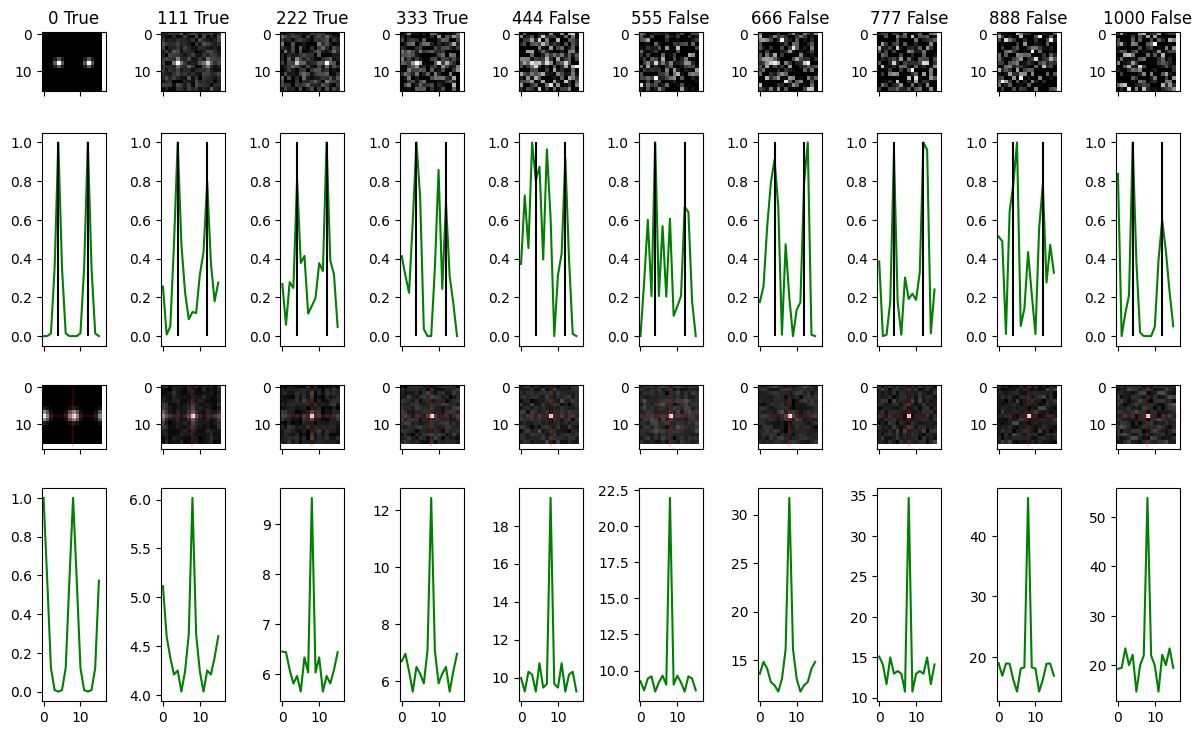

In [41]:
one_particle = Particles(
    x=[4, 12],
    y=[8, 8],
    z=[0, 0],
    size=[2, 2]
)

from scipy.fft import rfft2, irfft2, fftshift
def compute_fft_xcorr(imgA, imgB):
    """Computes the cross-correlation of two images using the Fourier method."""
    f2a = np.conj(rfft2(imgA))
    f2b = rfft2(imgB)
    return fftshift(irfft2(f2a * f2b).real, axes=(-2, -1))
    

import matplotlib.pyplot as plt
N = 10
fig, axs = plt.subplots(4, N, tight_layout=True, sharex=True,
                       figsize=(12, 8))

cam.particle_image_diameter = 2.5
for i, dark_noise in enumerate(np.linspace(0, 1000, N, dtype=int)):
    cam.dark_noise = dark_noise
    imgOne, partOne = take_image(laser, cam, one_particle, particle_peak_count=1000)
    axs[0][i].set_title(str(dark_noise)+' '+str(partOne.active[0]))
    axs[0][i].imshow(imgOne, cmap='gray')
    axs[1][i].plot(imgOne[8, :]/imgOne[8, :].max(), color='g')
    # axs[1][i].plot(imgOne[:, 8]/imgOne[:, 8].max(), color='r')
    axs[1][i].vlines(4, 0, 1, color='k')
    axs[1][i].vlines(12, 0, 1, color='k')
    auto_corr = compute_fft_xcorr(imgOne[:], imgOne[:])
    if i==0:
        corr_norm = auto_corr.max()
    axs[2][i].imshow(auto_corr/corr_norm, cmap='gray')
    axs[2][i].vlines(8, 0, 16, color='r', alpha=0.2)
    axs[2][i].hlines(8, 0, 16, color='r', alpha=0.2)
    axs[3][i].plot(auto_corr[8, :]/corr_norm, color='g')
    # axs[3][i].plot(auto_corr[:, 8]/corr_norm, color='r')